In [1]:
%matplotlib inline
import random
import os
import numpy as np
import matplotlib.pyplot as plt

# Data and utils

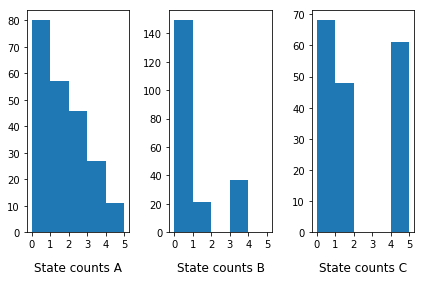

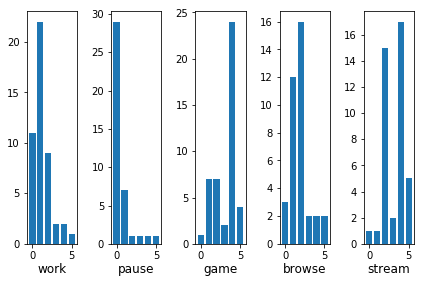

In [31]:
users = ["A", "B", "C"]  # the three users we are interested in
states = {"work": 0, "pause": 1, "game": 2, "browse": 3, "stream": 4}   # their states (activities)
states_inv = {v: k for k, v in states.items()}
observations = {"none": 0, "very_low": 1, "low": 2, "medium": 3, "high": 4, "very_high": 5}   # our observations (LED blinking frequency)
observations_inv = {v: k for k, v in observations.items()}

def convert_state(state):
    return states[state]


def convert_observation(observation):
    return observations[observation]

def convert_state_observation(state_observation, sep=','):
    state, observation = state_observation.split(sep)
    return (convert_state(state), convert_observation(observation))


def load_activities(users):
    """ Loads activities for all users from file """
    activities_data = {}   # map user -> activties_data
    for u in users:
        # load activities CSV
        path = os.path.join("data", u + "_activities.csv")
        data = np.genfromtxt(path, dtype='unicode', delimiter='|')
        # we are only interested in the second column
        # and map the activity names to indices
        activities_data[u] = [list(map(convert_state, d.split())) for d in data[:, 1]]
    return activities_data


def load_observations():
    """ Loads observations from file """
    # load observations CSV
    path = os.path.join("data", "observations.csv")
    data = np.genfromtxt(path, dtype='unicode', delimiter='|')
    
    # full matrix
    full_data = np.vstack((
              np.vectorize(states.get)(data[:, 0]),
              np.vectorize(observations.get)(data[:, 1]))).T
    
    # counts per activity, matrix activity x observation
    # dictionary with keys activity, values arrays 
    # as arr[observation] == count
    observation_counts = np.ones((len(states), len(observations)))
    for row in full_data:
        activity, observation = row
        observation_counts[activity][observation] += 1.0
    return (full_data, observation_counts)


def load_testsets(users):
    """ Load testsets from the files. """
    activities_data = {}   # map user -> activties_data
    for u in users:
        # load activities CSV
        path = os.path.join("data", u + "_testset.csv")
        data = np.genfromtxt(path, dtype='unicode', delimiter='|')
        # we are only interested in the second column
        # and map the activity/observation names to tuples of indices
        activities_data[u] = [list(map(convert_state_observation, d.split())) for d in data[:, 1]]
    return activities_data
    
    
def split_testset(activities_data, test_set_size=3):
    """ Splits activities data in training and test set """
    random.seed(1234)
    random.shuffle(activities_data)
    return (activities_data[test_set_size:],
            activities_data[:test_set_size])
    

def plot_transition_matrices(models):
    """ Plots transition matrices for the provided models """
    fig, axarr = plt.subplots(1, len(models))
    plt_num = 0
    for user in models:
        A = models[user][0]
        axarr[plt_num].matshow(A)
        axarr[plt_num].set_title("Transition matrix " + user, y=-0.3)
        plt_num += 1
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
    
def plot_graphs(models):
    """ Plots graphs for the provided models """
    import networkx as nx
    fig, axarr = plt.subplots(1, len(models))
    plt_num = 0
    for user in models:
        A = models[user][0]
        G = nx.from_numpy_matrix(A)
        nx.draw(G)
        axarr[plt_num].set_title("Transition matrix " + user, y=-0.3)
        plt_num += 1
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def plot_results(results_matrix):
    """ Plots classification results """
    fig = plt.figure(figsize=(100,100))
    plt.matshow(results_matrix)
    plt.show()
    plt.close(fig)


def plot_models(models):
    # chain model
    # if (len(model) == 2):
    plot_transition_matrices(models)
    #plot_graphs(models)

    
def plot_observation_counts(observation_counts):
    """ Plots transition matrices for the provided models """
    fig, axarr = plt.subplots(1, len(observation_counts))
    plt_num = 0
    for idx, row in enumerate(observation_counts):
        counts = [int(c) for c in row]
        axarr[plt_num].bar(range(len(counts)), counts)
        axarr[plt_num].set_title(states_inv[idx], y=-0.15)
        plt_num += 1
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def plot_activities(activities_data):
    fig, axarr = plt.subplots(1, len(activities_data))
    plt_num = 0
    for user in activities_data:
        user_activities = activities_data[user]
        flat_activites = [i for sl in user_activities for i in sl]
        bins = sorted(states.values())
        bins.append(len(states))
        axarr[plt_num].hist(flat_activites, bins=bins)
        axarr[plt_num].set_xticks(bins)
        axarr[plt_num].set_title("State counts " + user, y=-0.2)
        plt_num += 1
    plt.tight_layout()
    plt.show()
    plt.close(fig)


# load data into global variables
activities_data = load_activities(users)
testset_data = load_testsets(users)
observations_data, observations_counts = load_observations()

plot_activities(activities_data)
plot_observation_counts(observations_counts)

# Task 1: Markov chain model

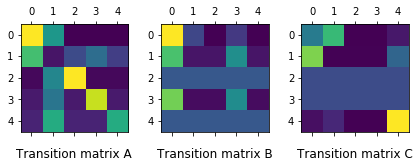

Testing on data for user A
[[8.40756212e-01 9.99097165e-01 9.99946472e-01 9.99097165e-01
  9.99677528e-01]
 [1.71287318e-02 8.54327351e-04 2.75869551e-05 8.54327351e-04
  2.84087454e-04]
 [1.42115056e-01 4.85073112e-05 2.59411581e-05 4.85073112e-05
  3.83845438e-05]]


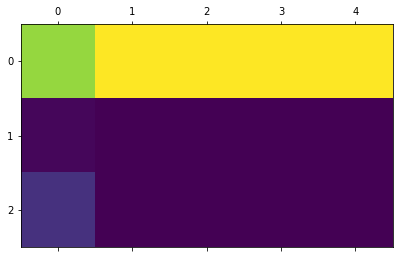

Testing on data for user B
[[3.98003791e-03 2.45955977e-04 6.83724738e-03 2.52935637e-04
  1.09866384e-03]
 [9.96003647e-01 9.99581723e-01 9.92164725e-01 9.98476554e-01
  9.98871963e-01]
 [1.63148622e-05 1.72320847e-04 9.98027206e-04 1.27050990e-03
  2.93728766e-05]]


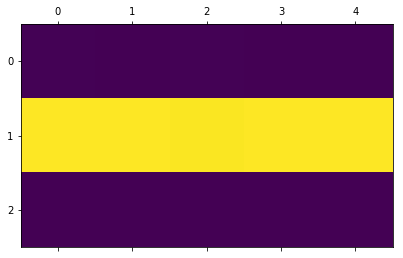

Testing on data for user C
[[1.59500010e-02 7.79300387e-03 1.59500010e-02 5.95648867e-03
  1.59500010e-02]
 [1.87920082e-04 8.31299669e-05 1.87920082e-04 4.79226286e-06
  1.87920082e-04]
 [9.83862079e-01 9.92123866e-01 9.83862079e-01 9.94038719e-01
  9.83862079e-01]]


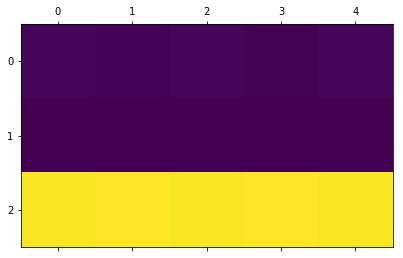

In [32]:
def init_chain_model(states):
    """ Initialize an empy Markov chain model """
    # transition probability matrix
    A = np.zeros((len(states), len(states)))
    
    # initial state probability vector
    I = np.zeros((1, len(states)))
    
    return (A, I)


def train_chain_model(model, activities_data):
    """ Trains a Markov chain model given activities_data """
    # get transition matrix and initial transition vector from model tuple
    A, I = model
    
    # get a counts matrix of same size as A
    # we use "ones_like" instead of "zeroes_like" so that
    # when normalizing we don't get divisions by zero
    # at the same time achieves Laplace smoothing
    # https://en.wikipedia.org/wiki/Additive_smoothing
    A_counts = np.ones_like(A)
    I_counts = np.ones_like(I)
    
    # loop over sequences (one sequence per day)
    for seq in activities_data:
        # get initial activity for this dy
        I_counts[0, seq[0]] += 1
        
        # loop activities in this day
        for idx in range(1, len(seq)):
            
            # TASK TODO: get current and last activity
            # and increase the according entry in the 
            # transition count matrix
            curr = seq[idx]
            last = seq[idx-1]
            A_counts[last, curr] += 1
            
    # normalize matrix rows to get probabilites
    # (so that the sum of each row is 1.0)
    # sum up rows, and then divide using broadcasting
    # https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    A = A_counts / A_counts.sum(axis=1, keepdims=True)
    I = I_counts / I_counts.sum(axis=1, keepdims=True)
    return (A, I)


def predict_chain_model(model, activities_data):
    """ Run prediction on a Markov Chain model """
    A, I = model
    
    predictions = []
    # loop sequences (daily activities)
    for seq_idx, seq in enumerate(activities_data):
        # get initial property for first state
        seq_prob = I[0, seq[0]]
        
        # loop activities per day
        for idx in range(1, len(seq)):
            # TASK TODO: get current and last activity
            # get the transition probability P(curr|last)
            curr = seq[idx]
            last = seq[idx-1]
            seq_prob = seq_prob * A[last, curr]
        predictions.append(seq_prob)
    return predictions


# train our models
chain_models = {}
test_data = {}
for user in activities_data:
    user_activities_data = activities_data[user]
    user_train_data, user_test_data = split_testset(user_activities_data, 5)
    
    # store test data
    test_data[user] = user_test_data
    
    # initialize and then train model
    chain_model = init_chain_model(states)
    chain_model = train_chain_model(chain_model, user_train_data)
    chain_models[user] = chain_model
    
# plot our trained models
plot_models(chain_models)
    
# test on held-out data 
for user_data in test_data:
    print ("Testing on data for user " + user_data)
    # Calculate predictions for all models
    predictions = [predict_chain_model(chain_models[user_model], test_data[user_data]) 
                   for user_model in chain_models]
    
    # Now we have a matrix of the form (users, test_activities)
    results = np.array(predictions)
    
    # Normalize
    results /= results.sum(axis=0, keepdims=True)
    
    # Show normalized results
    print (results)
    plot_results(results)

# Task 2: Hidden Markov model

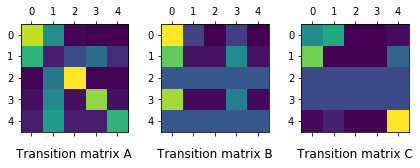

Testing on data for user A
[[9.99743468e-01 9.99652721e-01 9.69214581e-01 9.99852709e-01
  9.99852709e-01]
 [2.54697907e-04 3.43109022e-04 3.02445153e-02 1.38378090e-04
  1.38378090e-04]
 [1.83364064e-06 4.16952343e-06 5.40903315e-04 8.91245773e-06
  8.91245773e-06]]


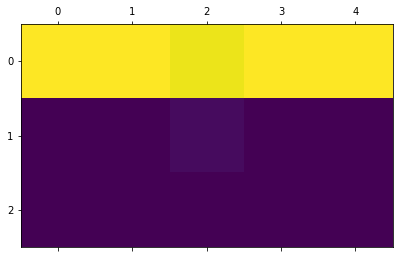

Testing on data for user B
[[2.99155900e-04 1.68185467e-01 1.40841033e-04]
 [9.99677191e-01 8.28936280e-01 9.99837777e-01]
 [2.36527987e-05 2.87825217e-03 2.13819253e-05]]


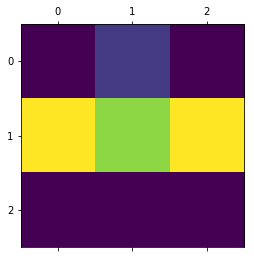

Testing on data for user C
[[9.96190276e-01 9.38037013e-01 8.13550549e-01 9.96551142e-01]
 [3.78546911e-03 1.91075623e-02 6.24156061e-03 3.25968379e-03]
 [2.42553853e-05 4.28554248e-02 1.80207890e-01 1.89174370e-04]]


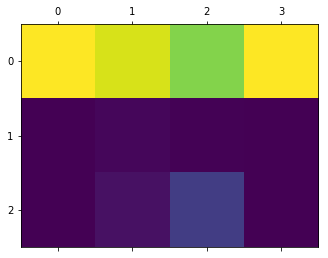

In [37]:
def init_hidden_markov_model(states, observations):
    """Initialize an empy hidden Markov model
    
    Zero-initializes the model parameters for a hidden Markov model.
    
    # Returns
        Model as tuple (A, I, O) with transition matrix, initial state vector and 
        observation probabilities matrix respectively.
    """
    # transition probability matrix (States x States)
    A = np.zeros((len(states), len(states)))
    
    # initial state probability vector (1 x States)
    I = np.zeros((1, len(states)))
    
    # observation probabilities matrix (States x Observations)
    O = np.zeros((len(states), len(observations)))
    
    return (A, I, O)


def train_hidden_markov_model(model, activities_data, observations_counts):
    """Trains a hidden Markov model.
    
    Given activities data and observation counts, trains a hidden Markov model.
    As we do have activities data available, training becomes simple counting and normalizing.
    If we only had observations, we would have to use an algorithm like Baum-Welch.
    (see for example http://www.sfs.uni-tuebingen.de/resources/em.pdf)
    
    # Arguments
        model: Model generated by init_hidden_markov_model
        activities_data: Data on user activities
        observations_counts: Counts per observation
    """
    # get transition matrix, initial transition vector and observations matrix from model tuple
    A, I, O = model
    
    # get a counts matrix of same size as A
    # we use "ones_like" instead of "zeroes_like" so that
    # when normalizing we don't get divisions by zero
    # at the same time achieves Laplace smoothing
    # https://en.wikipedia.org/wiki/Additive_smoothing
    A_counts = np.ones_like(A)
    I_counts = np.ones_like(I)
    
    # loop over sequences (one sequence per day)
    for seq in activities_data:
        # get initial activity for this dy
        I_counts[0, seq[0]] += 1
        
        # loop activities in this day
        for idx in range(1, len(seq)):
            
            # TASK TODO: get current and last activity
            # and increase the according entry in the 
            # transition count matrix
            curr = seq[idx]
            last = seq[idx-1]
            A_counts[last, curr] += 1
            
    # normalize matrix rows to get probabilites
    # (so that the sum of each row is 1.0)
    # sum up rows, and then divide using broadcasting
    # https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    A_norm = A_counts / A_counts.sum(axis=1, keepdims=True)
    I_norm = I_counts / I_counts.sum(axis=1, keepdims=True)
    O_norm = observations_counts / observations_counts.sum(axis=1, keepdims=True)
    return (A_norm, I_norm, O_norm)


def predict_hidden_markov_model(model, test_data, use_states=True):
    """Run prediction on a hidden Markov model. 
    
    Predict the probability of a given sequence of activities or observations.
    
    If use_states is True, state (activity) information can be used - we can easily calculate
    the total probability with the product of the individual probabilities of the sequence.
    This is then a Markov chain model with observations, as the states (activities) are not hidden.
    
    If use_states is False, the states (activities) are hidden and we have to find the most likely sequence
    in a hidden Markov model.
    
    # Arguments:
        model: A trained hidden Markov model
        test_data: Sequence of tuples of (state, observation)
        use_states: Use given state information or ignore and predict it
    """
    A, I, O = model
    
    predictions = []
    
    # loop sequences (one sequence per day)
    for seq_idx, seq in enumerate(test_data):
        # get initial property for first state
        seq_prob = I[0, seq[0][0]]

        # loop activities/observations for this day
        for idx in range(1, len(seq)):
            # TASK TODO: get current and last activity
            # get the transition probability P(curr|last)
            curr_state, curr_obs = seq[idx]
            last_state, _ = seq[idx-1]
            
            seq_prob = seq_prob * A[last_state, curr_state] * O[curr_state, curr_obs]
        predictions.append(seq_prob)
    return predictions


# train our models
models = {}
for user in activities_data:
    user_activities_data = activities_data[user]
    
    # initialize and then train model
    model = init_hidden_markov_model(states, observations)
    model = train_hidden_markov_model(model, user_activities_data, observations_counts)
    models[user] = model
    
# plot our trained models
plot_models(models)
    
# test on extra testsets
for user_data in testset_data:
    print ("Testing on data for user " + user_data)
    # Calculate predictions for all models
    predictions = [predict_hidden_markov_model(models[user_model], testset_data[user_data]) 
                   for user_model in models]
    
    # Now we have a matrix of the form (users, test_activities)
    results = np.array(predictions)
    
    # Normalize
    results /= results.sum(axis=0, keepdims=True)
    
    # Show normalized results
    print (results)
    plot_results(results)